<a href="https://colab.research.google.com/github/m-mazurkiewicz/PWR_MachineLearning/blob/AlexNet_master/AlexNetArchitecture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D as Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization

import sys
from keras.preprocessing.image import ImageDataGenerator, array_to_img, save_img
from matplotlib import pyplot as plt
import skimage.io as io
import numpy as np
import os
from tqdm import tqdm
from google.colab import drive
import keras

Using TensorFlow backend.


In [2]:
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [0]:
num_of_classes = 4
base_dir_processed = '/content/gdrive/My Drive/PWr_AlexNet_data/processed/'
data_set = 'no-padding/resize/'

In [0]:
BATCH_SIZE = 128
VALIDATION_SPLIT = 0.1

In [0]:
image_gen = ImageDataGenerator(
    featurewise_center=True,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    brightness_range=(0.5,1.5),
    shear_range=0.01,
    zoom_range=0.1,
    fill_mode='nearest',
    horizontal_flip=True,
    validation_split=VALIDATION_SPLIT
)

In [6]:
number_of_images_for_fit = -1

all_images = []
for class_name in os.listdir(base_dir_processed + data_set + 'train'):
  for image_path in tqdm(os.listdir(base_dir_processed + data_set + 'train/' + class_name)[:number_of_images_for_fit]):
    img = io.imread(base_dir_processed + data_set + 'train/' + class_name + '/' + image_path)
    all_images.append(img)
x_train = np.array(all_images)

image_gen.fit(x_train)

generator = image_gen.flow_from_directory(
    base_dir_processed + data_set + '/' + 'train',
        target_size=(227,227),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='training')

validation_generator = image_gen.flow_from_directory(
    base_dir_processed + data_set + '/' + 'train',
        target_size=(227,227),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='validation')

100%|██████████| 1109/1109 [00:04<00:00, 272.44it/s]


Found 4693 images belonging to 4 classes.
Found 520 images belonging to 4 classes.


In [0]:
# image_gen_test = ImageDataGenerator(featurewise_center=True)
# image_gen_test.fit(x_train)
# test_generator = image_gen_test.flow_from_directory(
#     base_dir_processed + data_set + '/' + 'test',
#         target_size=(227,227),
#         batch_size=BATCH_SIZE,
#         class_mode='categorical')

#Model

In [0]:
model = Sequential()

In [0]:
model.add(Conv2D(filters=96, input_shape=(227,227,3), kernel_size=(11,11), strides=(4,4), padding='valid'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))

In [0]:
model.add(Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))

In [0]:
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
model.add(Activation('relu'))

In [0]:
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
model.add(Activation('relu'))

In [0]:
model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))

In [0]:
model.add(Flatten())

In [0]:
model.add(Dense(4096))
model.add(Activation('relu'))
model.add(Dropout(0.5))

In [0]:
model.add(Dense(4096))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())

In [0]:
model.add(Dense(4))
model.add(Activation('softmax'))

In [18]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 55, 55, 96)        34944     
_________________________________________________________________
activation_1 (Activation)    (None, 55, 55, 96)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 55, 55, 96)        384       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 27, 256)       614656    
_________________________________________________________________
activation_2 (Activation)    (None, 27, 27, 256)       0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 27, 27, 256)       1024      
__________

In [0]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])

# Model saving preparation

In [0]:
MODEL_NAME = 'base_alexnet_resize'

In [0]:
base_dir_saving = '/content/gdrive/My Drive/PWr_AlexNet_models/'
model_path = data_set + '{}/'.format(BATCH_SIZE)
os.makedirs(base_dir_saving+model_path,  exist_ok=True)

In [22]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.001)
model_checkpoint = keras.callbacks.ModelCheckpoint(base_dir_saving+model_path+MODEL_NAME+'.h5',
                                                   monitor='val_acc', verbose=0, save_best_only=True, period=1)
hist = model.fit_generator(generator, steps_per_epoch=(5213*(1-VALIDATION_SPLIT)) // BATCH_SIZE, validation_data=validation_generator, validation_steps=4, epochs=100, verbose=1,
                           callbacks=[reduce_lr, model_checkpoint])

Epoch 1/100
36/36 [==============================] - 117s 3s/step - loss: 1.5747 - acc: 0.4286 - val_loss: 3.8027 - val_acc: 0.3398
Epoch 2/100
36/36 [==============================] - 87s 2s/step - loss: 1.2454 - acc: 0.5104 - val_loss: 1.5456 - val_acc: 0.3265
Epoch 3/100
36/36 [==============================] - 86s 2s/step - loss: 1.2180 - acc: 0.5085 - val_loss: 2.1715 - val_acc: 0.3087
Epoch 4/100
36/36 [==============================] - 86s 2s/step - loss: 1.1593 - acc: 0.5248 - val_loss: 0.9798 - val_acc: 0.6276
Epoch 5/100
36/36 [==============================] - 87s 2s/step - loss: 1.1737 - acc: 0.5124 - val_loss: 1.3469 - val_acc: 0.4133
Epoch 6/100
36/36 [==============================] - 85s 2s/step - loss: 1.0528 - acc: 0.5505 - val_loss: 0.9297 - val_acc: 0.5605
Epoch 7/100
36/36 [==============================] - 85s 2s/step - loss: 1.0180 - acc: 0.5683 - val_loss: 1.1082 - val_acc: 0.4923
Epoch 8/100
36/36 [==============================] - 88s 2s/step - loss: 0.9739 - 

# Plotting

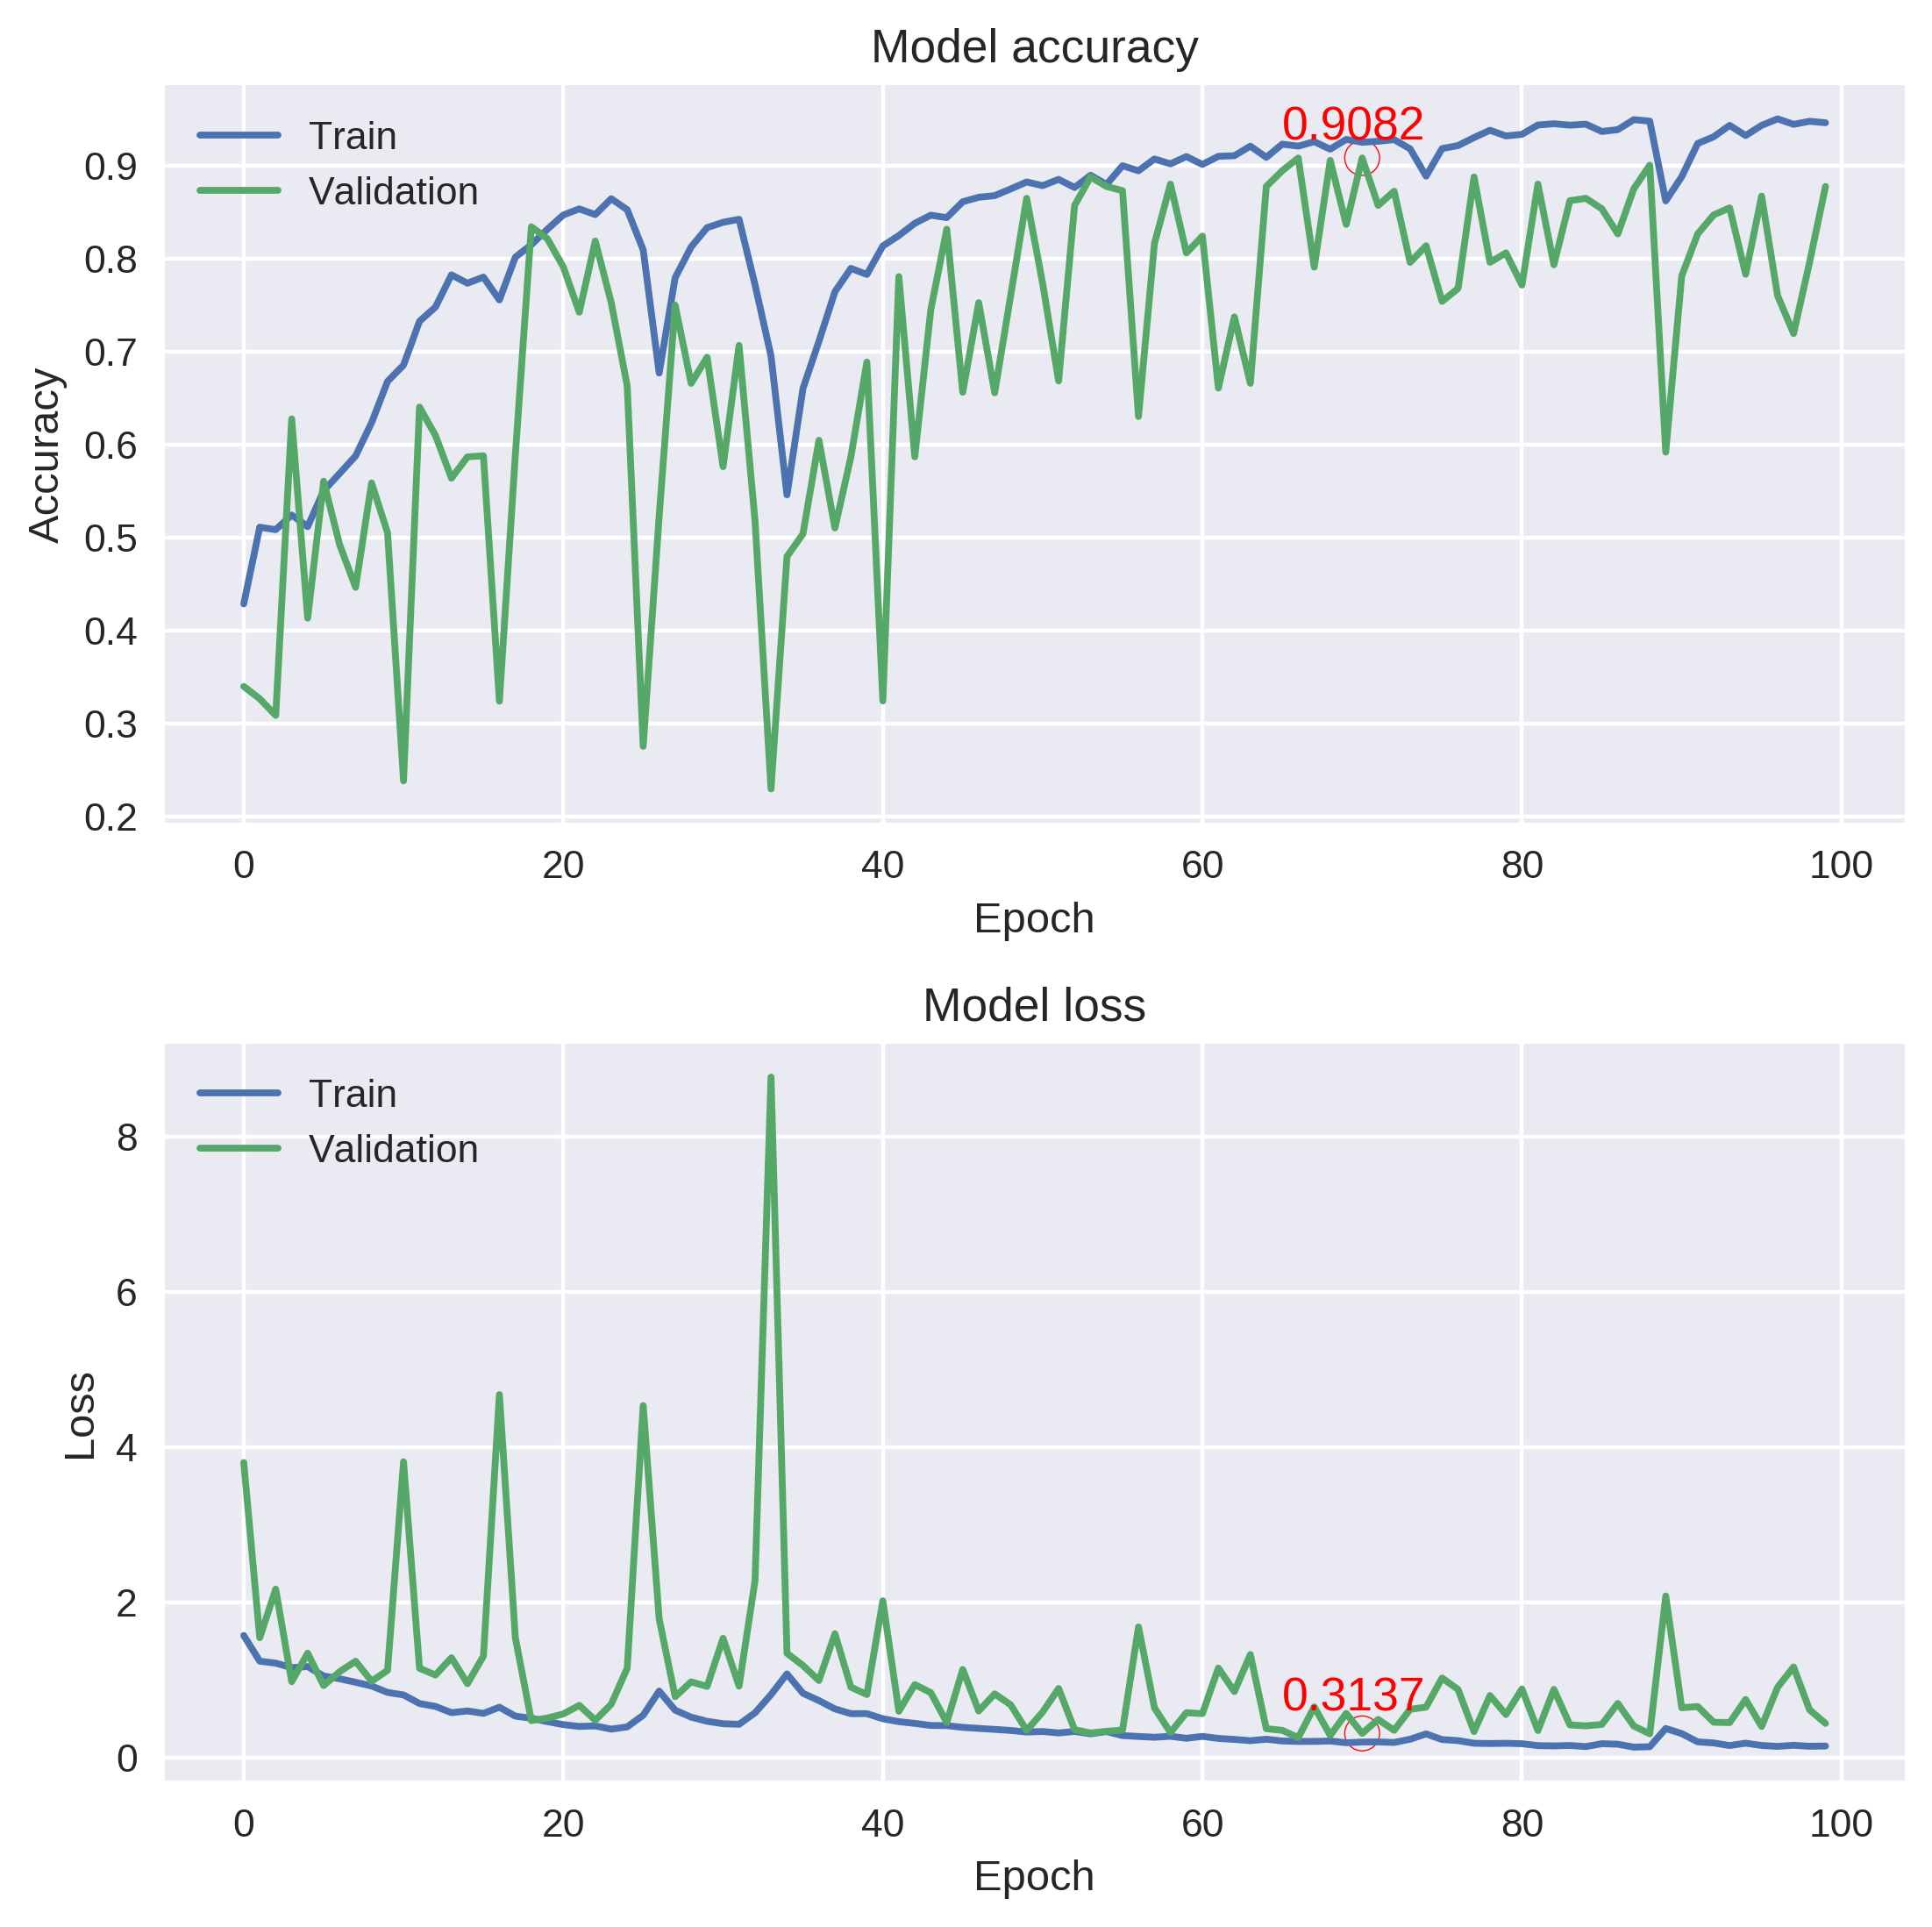

In [39]:
plt.figure(figsize=(8, 8), dpi=320)

max_val_acc_arg = np.argmax(hist.history['val_acc'])

plt.subplot(211)
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.scatter(max_val_acc_arg,hist.history['val_acc'][max_val_acc_arg], s=80, facecolors='none', edgecolors='r')
plt.annotate('{0:.4f}'.format(hist.history['val_acc'][max_val_acc_arg]),xy=(max_val_acc_arg-5,hist.history['val_acc'][max_val_acc_arg]+0.02),color='r')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplots_adjust(hspace = .3)

# Plot training & validation loss values
plt.subplot(212)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.scatter(max_val_acc_arg,hist.history['val_loss'][max_val_acc_arg], s=80, facecolors='none', edgecolors='r')
plt.annotate('{0:.4f}'.format(hist.history['val_loss'][max_val_acc_arg]),xy=(max_val_acc_arg-5,hist.history['val_loss'][max_val_acc_arg]+0.3),color='r')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.savefig(base_dir_saving+model_path+MODEL_NAME+'.pdf')
plt.show()